In [83]:
import os
import numpy as np
import datetime
from tensorflow_core.python.keras.callbacks import EarlyStopping
from tensorflow_core.python.keras.utils import np_utils
from tensorflow_core.python.keras.models import Sequential
from tensorflow_core.python.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.python import math_ops
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow_core.python.keras.layers import Activation
from tensorflow_core.python.keras.utils import get_custom_objects   # 自定義gelu

np.random.seed(10)

In [84]:

sentence_type = 'SA1'
# sentence_type = 'SA2'
# sentence_type = 'SA'
# sentence_type = 'SX'

Tr_ver = 'orig_50_DR25_M_'
Te_ver = 'orig_50_DR25_M_'
# --------------------------------------------------
Tr_ver = 'pe_50_DR25_M_'
Te_ver = 'pe_50_DR25_M_'

Tr_ver += sentence_type + '_'
Te_ver += sentence_type + '_'

Tr_ver += '2_'
Te_ver += '2_'

shape = 50

now_path = r'D:\TIMITDIC_231101'
data_path = now_path + '_data_CLIPS'

Tr_CDF_path = os.path.join(data_path, 'TRAIN', 'cnn_dataset_librosa')
Te_CDF_path = os.path.join(data_path, 'TEST', 'cnn_dataset_librosa')

Tr_DS_path = os.path.join(Tr_CDF_path, 'mfcc', Tr_ver + 'SoundDataset.npz')

Te_DS_path = os.path.join(Te_CDF_path, 'mfcc', Te_ver + 'SoundDataset.npz')

In [85]:
Tr_DS = np.load(Tr_DS_path)
Te_DS = np.load(Te_DS_path)

train_value, train_label = Tr_DS['TrainValue'], Tr_DS['TrainLabel_class']
test_value, test_label = Te_DS['TestValue'], Te_DS['TestLabel_class']
# test_value, test_label, test_label2 = Te_DS['TestValue'], Te_DS['TestLabel_class'], Te_DS['TestLabel_type']

train_value_4D = train_value.reshape(train_value.shape[0], shape, shape, 1).astype('float32')
test_value_4D = test_value.reshape(test_value.shape[0], shape, shape, 1).astype('float32')

# 向量轉換為二進制(只有0和1)的矩陣類型
# 但train_label、test_label原先資料就都是0跟1?
train_label_OneHot = np_utils.to_categorical(train_label)
test_label_OneHot = np_utils.to_categorical(test_label)

In [86]:
class Davis( Activation ):    
    def __init__(self, activation, **kwargs):
        super(Davis, self).__init__(activation, **kwargs)
        self.__name__ = 'custom_gelu'

def custom_gelu(x):
    return 0.5 * x * (1 + math_ops.tanh(math_ops.sqrt(2 / np.pi) * (x + 0.044715 * math_ops.pow(x, 3))))

get_custom_objects().update({'custom_gelu': Davis(custom_gelu)})
get_custom_objects().update({'Davis': (Activation)})

In [87]:
activation_cate = 'relu'
# activation_cate = 'custom_gelu'
# activation_cate = 'sigmoid'
# activation_cate = 'elu'
# activation_cate = 'tanh'
kernel_size = 3

model = Sequential()
model.add(Conv2D(32, (kernel_size, kernel_size), input_shape=(shape, shape, 1), padding='same', activation=activation_cate))
model.add(Conv2D(32, (kernel_size, kernel_size), padding='same', activation=activation_cate))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(32, (kernel_size, kernel_size), padding='same', activation=activation_cate))
model.add(Conv2D(64, (kernel_size, kernel_size), padding='same', activation=activation_cate))
# model.add(Conv2D(128, (3, 3), padding='same', activation='custom_gelu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

# model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))

# model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))

# model.add(Conv2D(1024, (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(1024, (3, 3), padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))

model.add(Flatten())
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(256, activation='custom_gelu'))
# model.add(Dropout(0.5))
# model.add(Dense(64, activation=activation_cate))
# model.add(Dropout(0.2))
model.add(Dense(128, activation=activation_cate))
model.add(Dropout(0.5))
# model.add(Dense(32, activation=activation_cate))
# model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [88]:
model.summary()
model.compile(loss='binary_crossentropy',  # mean_squared_error, binary_crossentropy, categorical_crossentropy
              optimizer="adam",  # sgd, rmsprop, adam
              metrics=['accuracy'])

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 50, 50, 32)        320       
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 50, 50, 32)        9248      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 25, 25, 32)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 25, 25, 32)        9248      
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 12, 12, 64)       

In [89]:
# 創建一個早停法的回調函數
# early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
# early_stopping = EarlyStopping(monitor='val_acc', patience=100, restore_best_weights=True)

train_history=model.fit(x=train_value_4D,
                        y=train_label_OneHot,
                        validation_split=0.2,
                        epochs=100,
                        batch_size=10,
                        verbose=2,
                        # callbacks=[early_stopping])
                        )

Train on 58 samples, validate on 15 samples
Epoch 1/100
58/58 - 1s - loss: 0.6807 - acc: 0.6034 - val_loss: 0.4645 - val_acc: 0.8667
Epoch 2/100
58/58 - 0s - loss: 0.7314 - acc: 0.6552 - val_loss: 0.6271 - val_acc: 0.8667
Epoch 3/100
58/58 - 0s - loss: 0.6493 - acc: 0.6897 - val_loss: 0.5138 - val_acc: 0.8667
Epoch 4/100
58/58 - 0s - loss: 0.6525 - acc: 0.6897 - val_loss: 0.6104 - val_acc: 0.8667
Epoch 5/100
58/58 - 0s - loss: 0.6429 - acc: 0.6897 - val_loss: 0.5542 - val_acc: 0.8667
Epoch 6/100
58/58 - 0s - loss: 0.6002 - acc: 0.6897 - val_loss: 0.4725 - val_acc: 0.8667
Epoch 7/100
58/58 - 0s - loss: 0.6326 - acc: 0.6897 - val_loss: 0.4533 - val_acc: 0.8667
Epoch 8/100
58/58 - 0s - loss: 0.6193 - acc: 0.6897 - val_loss: 0.5262 - val_acc: 0.8667
Epoch 9/100
58/58 - 0s - loss: 0.5944 - acc: 0.6897 - val_loss: 0.4789 - val_acc: 0.8667
Epoch 10/100
58/58 - 0s - loss: 0.5596 - acc: 0.6897 - val_loss: 0.3936 - val_acc: 0.8667
Epoch 11/100
58/58 - 0s - loss: 0.4854 - acc: 0.6897 - val_loss: 

{'loss': [0.6806639186267195, 0.7314463165299646, 0.6492961963702892, 0.6525080409543268, 0.642877434862071, 0.6001647073647072, 0.6326021264339315, 0.6192500303531515, 0.5943608941703007, 0.5596383635340065, 0.4854362637832247, 0.3986570578196953, 0.3210443057890596, 0.3084421445583475, 0.2638971582055092, 0.2354996702794371, 0.22066120854739485, 0.14551570086643614, 0.06925550636289449, 0.2143826965114166, 0.07464209868540538, 0.06130205663242217, 0.02091996975500008, 0.03711969344394988, 0.049829454129112175, 0.04135948630724231, 0.004760383110461307, 0.0057022774527812825, 0.005493736415419021, 0.0033958561092229753, 0.0028716730584133544, 0.0021376513696881815, 0.001914411096518522, 0.0029988851524178936, 0.002333515542479039, 0.002719221289351418, 0.002048907137138705, 0.001671112733612094, 0.0009884032065044799, 0.0007520443199108081, 0.001006860247861337, 0.0005573485285477264, 0.0002828723312443893, 0.00035816266719048773, 0.0005510689496641762, 0.0007783662957332, 0.000190412

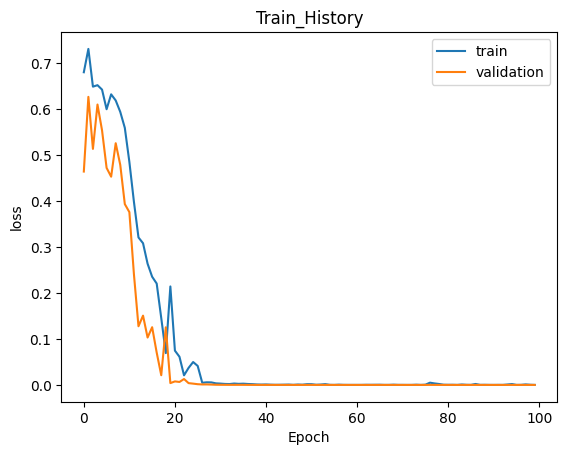

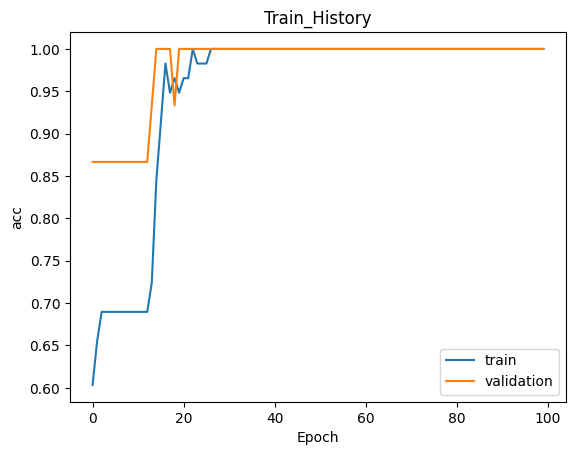

In [90]:
now_str = datetime.datetime.now()
now_str = datetime.datetime.strftime(now_str, '%Y%m%d_%H%M%S')

def show_train_history(train_history, train, validation):
    # 定義show_train_history函數，輸入下列參數:之前訓練過程所產生的train_history、
    # ...訓練資料的執行結果、驗證資料的執行結果
    print(train_history.history)
    plt.style.use('default')
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train_History')  # 顯示圖的標題
    plt.ylabel(train)  # 顯示y軸的標籤
    plt.xlabel('Epoch')  # 設定x軸標籤是'Epoch'
    plt.legend(['train', 'validation'], loc='best')
    # 設定國例是顯示'train', 'validation',位置在左上角

    train_history_path = os.path.join(now_path, 'train_history', Tr_ver)
    os.makedirs(train_history_path, exist_ok=True)

    plt.savefig(os.path.join(train_history_path, now_str + '_' + train + '.png'), bbox_inches='tight', pad_inches=0)

    plt.show()

show_train_history(train_history, 'loss', 'val_loss')
show_train_history(train_history, 'acc', 'val_acc')
# show_train_history(train_history, 'accuracy', 'val_accuracy')

In [91]:
scores = model.evaluate(test_value_4D, test_label_OneHot)
print('loss=', scores[0], '\nacc=', scores[1])

f = open(os.path.join(now_path, 'train_history', 'train_history.txt'), 'a+')  # a+

content = f.read()
f.seek(0, 0)

f.write('\n' + '---------------------------------' + '\n')
f.write('\n' + '*****' + Tr_ver + '*****' + '\n')
f.write(now_str + '\n')
f.write('loss=' + '\n' + str(scores[0]) + '\n')
f.write('acc=' + '\n' + str(scores[1]))

f.write('\n' + content)
f.close()

24/24 [==============================] - 0s 147us/sample - loss: 3.4683e-06 - acc: 1.0000
loss= 3.4682864225032972e-06 
acc= 1.0


In [92]:
# 使用pd.crosstab建立混淆矩陣，輸入下列參數:
prediction = model.predict_classes(test_value_4D)
pd.crosstab(test_label,  # 測試資料數字影像的其實值
            prediction,  # 測試資料數字影像的預測結果
            rownames=['label'],  # 設定行的名稱是label
            colnames=['predict'])  # 設定列的名稱是predict

predict,0,1
label,,
0,18,0
1,0,6


In [93]:
MWpath = os.path.join(now_path, '..\..', 'model_weight')
os.makedirs(MWpath, exist_ok=True)
Wver = now_path.split('\\')[-1]
model.save(os.path.join(MWpath, Tr_ver + 'SoundWeight_' + Wver + '_type2.h5'))